In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/design_lab

/content/drive/MyDrive/design_lab


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import tensorflow as tf
from tqdm.autonotebook import tqdm

In [ ]:
rx_data = pd.read_csv('OOK_rx_data.csv')
column = []
for i in range(0,512):
  column.append("column #{}".format(i+1))
rx_data.columns = column
print(len(rx_data))
rx_data.head()

39000


,column #1,column #2,column #3,column #4,column #5,column #6,column #7,column #8,column #9,column #10,...,column #503,column #504,column #505,column #506,column #507,column #508,column #509,column #510,column #511,column #512
0,0.011762,0.017573,0.005295,0.003670,-0.000911,0.012518,0.004868,0.010825,0.004837,-0.001861,...,-0.001224,0.006594,0.005051,0.011162,0.008994,0.013921,0.006607,-0.003100,0.019360,0.007070
1,0.014433,0.009893,-0.002636,0.004490,0.012676,0.009384,0.002691,-0.002062,0.000729,-0.000533,...,0.001825,0.017155,0.004683,-0.002123,0.012454,0.022536,0.004251,-0.001792,0.002818,0.014904
2,-0.002203,0.004304,-0.002167,-0.000022,-0.004415,-0.002640,0.007933,0.023642,0.021970,0.018397,...,0.014583,0.010935,0.002738,0.004617,0.012897,0.009061,0.014389,0.019500,0.017932,0.019471
3,0.013119,0.009051,0.017413,0.021497,0.011239,0.011628,0.016123,0.013480,0.017927,0.006823,...,0.022507,0.004713,-0.001422,0.009819,0.018007,0.003946,0.019161,0.003096,-0.002994,0.018737
4,0.013252,0.023965,0.007160,0.010313,0.020467,0.014363,0.015693,0.006030,-0.000855,-0.002186,...,-0.003839,0.005674,-0.003932,0.004793,-0.006566,0.006015,0.009583,0.020400,0.006870,0.013827


In [ ]:
correct_data = pd.read_csv('OOK_correct_data.csv')
column = []
for i in range(0,512):
  column.append("column #{}".format(i+1))
correct_data.columns = column
print(len(correct_data))
correct_data.head()

39000


,column #1,column #2,column #3,column #4,column #5,column #6,column #7,column #8,column #9,column #10,...,column #503,column #504,column #505,column #506,column #507,column #508,column #509,column #510,column #511,column #512
0,1,1,0,0,0,1,0,1,0,0,...,0,1,0,1,0,1,0,0,1,0
1,1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,1,1,0,0,0,1
2,0,0,0,0,0,0,1,1,1,1,...,1,1,0,0,1,0,1,1,1,1
3,1,0,1,1,0,1,1,1,1,0,...,1,0,0,1,1,0,1,0,0,1
4,1,1,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,1,1,0,1


In [ ]:
snr_data = pd.read_csv('OOK_snr_data.csv')
snr_data

,snr_data
0,5
1,5
2,5
3,5
4,5
...,...
38995,30
38996,30
38997,30
38998,30


In [ ]:
def one_hot_encode(y):
  curr = []

  for i in range(0,len(y)):
    if y[i] == 0:
      curr.append([1, 0])
    else:
      curr.append([0, 1])

  return curr

X_test,X_train,Y_test,Y_train,snr_test, snr_train = [],[],[],[],[], []

for i, row in rx_data.iterrows():
  row = row.values
  if i % 10 == 8:
    X_test.append(row)
  else:
    X_train.append(row)

del rx_data


for i ,row in correct_data.iterrows():
  row = row.values
  row = one_hot_encode(row)
  if i % 10 == 8:
    Y_test.append(row)
  else:
    Y_train.append(row)

del correct_data


for i, row in snr_data.iterrows():
  if i % 10 == 8:
    snr_test.append(row["snr_data"])
  else:
    snr_train.append(row["snr_data"])

del snr_data

print(len(X_test))
print(len(X_train))
print(len(Y_test))
print(len(Y_train))

3900
35100
3900
35100


In [ ]:
X_train = np.array(X_train)
X_train = X_train.reshape(-1, X_train.shape[1], 1)

X_test = np.array(X_test)
X_test = X_test.reshape(-1,  X_test.shape[1], 1)

Y_train = np.array(Y_train)
Y_train = Y_train.reshape(-1, Y_train.shape[1],2)

Y_test = np.array(Y_test)
Y_test = Y_test.reshape(-1, Y_test.shape[1],2)

In [ ]:
def scale(arr):
  maxElement = np.max(arr)
  minElement = np.min(arr)
  meanElement = np.mean(arr)
  newArr = []

  for i in range(len(arr)):
    x = (arr[i]-meanElement)/(maxElement-minElement)
    if (x>1 or x<-1):
      print(arr[i])
    arr[i] = x
  return arr

def scaleData(data):
  
  for i in range(len(data)):
    data[i] = scale(data[i])
    # data[i] = np.array([0]*512)
  return data

In [ ]:
X_train = scaleData(X_train)
X_test = scaleData(X_test)
X_train

array([[[ 0.07480067],
        [ 0.23079842],
        [-0.09880499],
        ...,
        [-0.3241841 ],
        [ 0.27877194],
        [-0.05117363]],

       [[ 0.17288136],
        [ 0.03842936],
        [-0.33260493],
        ...,
        [-0.30760945],
        [-0.17109973],
        [ 0.18682344]],

       [[-0.30017254],
        [-0.12645863],
        [-0.29920656],
        ...,
        [ 0.27919855],
        [ 0.23733295],
        [ 0.27842345]],

       ...,

       [[ 0.16164168],
        [ 0.1070498 ],
        [ 0.05371992],
        ...,
        [-0.00626033],
        [ 0.16221465],
        [-0.02380605]],

       [[ 0.17881059],
        [ 0.12758622],
        [ 0.07605534],
        ...,
        [ 0.18157145],
        [-0.03393671],
        [-0.24738632]],

       [[-0.25569122],
        [-0.03655978],
        [ 0.23856442],
        ...,
        [ 0.006535  ],
        [ 0.16474222],
        [ 0.33351333]]])

In [ ]:
print(Y_test.shape)
print(X_test.shape)
print(Y_train.shape)
print(X_train.shape)

(3900, 512, 2)
(3900, 512, 1)
(35100, 512, 2)
(35100, 512, 1)


In [ ]:
import os
#import skimage.io as io
#import skimage.transform as trans
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Conv2D, Conv2DTranspose

#input_size = input_shape=(X_train.shape[1:])
#inputs = Input(input_size)

activation_layer = 'relu';
model = Sequential()
model.add(Dense(64,activation = activation_layer))
model.add(BatchNormalization())
#model.add(Activation(activation_layer))
model.add(Conv1D(2,1,activation='softmax'))
opt = SGD(learning_rate=0.01)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train,Y_train,batch_size=64,epochs = 20, validation_data=(X_test, Y_test))

Epoch 1/20
549/549 [==============================] - 18s 32ms/step - loss: 0.6359 - accuracy: 0.8937 - val_loss: 0.6000 - val_accuracy: 0.9094
Epoch 2/20
549/549 [==============================] - 17s 31ms/step - loss: 0.5676 - accuracy: 0.9196 - val_loss: 0.5331 - val_accuracy: 0.9259
Epoch 3/20
549/549 [==============================] - 17s 31ms/step - loss: 0.4961 - accuracy: 0.9289 - val_loss: 0.4590 - val_accuracy: 0.9304
Epoch 4/20
549/549 [==============================] - 17s 31ms/step - loss: 0.4240 - accuracy: 0.9314 - val_loss: 0.3913 - val_accuracy: 0.9319
Epoch 5/20
549/549 [==============================] - 17s 31ms/step - loss: 0.3635 - accuracy: 0.9323 - val_loss: 0.3386 - val_accuracy: 0.9324
Epoch 6/20
549/549 [==============================] - 19s 34ms/step - loss: 0.3182 - accuracy: 0.9326 - val_loss: 0.3004 - val_accuracy: 0.9325
Epoch 7/20
549/549 [==============================] - 17s 31ms/step - loss: 0.2856 - accuracy: 0.9327 - val_loss: 0.2729 - val_accuracy:

In [ ]:
y_pred = model.predict(X_test)
y_pred

array([[[6.6934325e-02, 9.3306571e-01],
        [9.0697891e-01, 9.3021043e-02],
        [9.9984610e-01, 1.5387841e-04],
        ...,
        [4.1700077e-01, 5.8299923e-01],
        [5.6892700e-02, 9.4310725e-01],
        [9.8262846e-01, 1.7371463e-02]],

       [[5.3801067e-02, 9.4619894e-01],
        [3.1695941e-01, 6.8304062e-01],
        [1.2563816e-03, 9.9874359e-01],
        ...,
        [9.9989462e-01, 1.0536645e-04],
        [1.5068308e-03, 9.9849319e-01],
        [2.7256041e-05, 9.9997270e-01]],

       [[7.6970912e-04, 9.9923027e-01],
        [8.5228741e-01, 1.4771266e-01],
        [9.9998975e-01, 1.0203192e-05],
        ...,
        [2.6858282e-01, 7.3141718e-01],
        [1.2357662e-03, 9.9876428e-01],
        [1.8779445e-01, 8.1220561e-01]],

       ...,

       [[9.9994802e-01, 5.1928240e-05],
        [9.9994206e-01, 5.7905327e-05],
        [9.9994135e-01, 5.8616690e-05],
        ...,
        [9.9111617e-01, 8.8838069e-03],
        [8.6272985e-01, 1.3727011e-01],
        [

In [ ]:
turb = {3:"Strong", 2:"Moderate",1:"Weak"}
ber_snr_turb = {}
for cn in range(1,4):
  pred_data = dict()
  for i in range(0,1300):
    x = (cn-1)*1300+i
    snr = snr_test[x]
    # print(snr)
    if snr not in pred_data.keys():
      pred_data[snr] = {"error" : 0, "total" : 0}
    error = 0

    
    for j in range(0,len(Y_test[x])):
      if (y_pred[x][j][0] > y_pred[x][j][1] and Y_test[x][j][0] < Y_test[x][j][1]) or (y_pred[x][j][0] < y_pred[x][j][1] and Y_test[x][j][0] > Y_test[x][j][1]):
        error+=1
      # if (y_pred[i][j] != Y_test[i][j]):
      #   error+=1

    pred_data[snr]["error"] += error
    pred_data[snr]["total"] += len(Y_test[x])
  #if turb[cn] not in ber_snr_turb.keys():
    #ber_snr_turb[turb[cn]] = {}
  ber_snr_turb[turb[cn]] = pred_data
x_data = []
y_data = dict()
for h in ber_snr_turb.keys():
  #print(h)
  y_data[h] = []
  for snr in ber_snr_turb[h].keys():
    x_data.append(snr)
    #cn.append(h)
    y_data[h].append(ber_snr_turb[h][snr]["error"]/ber_snr_turb[h][snr]["total"])
    print(h,ber_snr_turb[h][snr]["error"]/ber_snr_turb[h][snr]["total"])
#data = {"Turbulence":cn, "SNR":x_data, "BER":y_data}
#print(data)
df = pd.DataFrame(y_data,index = x_data[0:26])
df.to_csv('model2_metadata.csv')

Weak 0.1315625
Weak 0.1199609375
Weak 0.108359375
Weak 0.094296875
Weak 0.07921875
Weak 0.07109375
Weak 0.055078125
Weak 0.0412109375
Weak 0.0318359375
Weak 0.022421875
Weak 0.0164453125
Weak 0.0116015625
Weak 0.0058203125
Weak 0.00375
Weak 0.0031640625
Weak 0.001484375
Weak 0.001171875
Weak 0.0002734375
Weak 0.0028515625
Weak 0.0042578125
Weak 0.0001171875
Weak 0.00296875
Weak 0.0
Weak 0.0
Weak 0.0009765625
Weak 0.0
Moderate 0.1392578125
Moderate 0.128515625
Moderate 0.1143359375
Moderate 0.1049609375
Moderate 0.0898828125
Moderate 0.0761328125
Moderate 0.0666015625
Moderate 0.060859375
Moderate 0.05109375
Moderate 0.0429296875
Moderate 0.0379296875
Moderate 0.0294921875
Moderate 0.0260546875
Moderate 0.0227734375
Moderate 0.0196875
Moderate 0.017890625
Moderate 0.0130859375
Moderate 0.0134765625
Moderate 0.01171875
Moderate 0.01390625
Moderate 0.01109375
Moderate 0.01078125
Moderate 0.0100390625
Moderate 0.009609375
Moderate 0.007265625
Moderate 0.0089453125
Strong 0.167109375
Strong

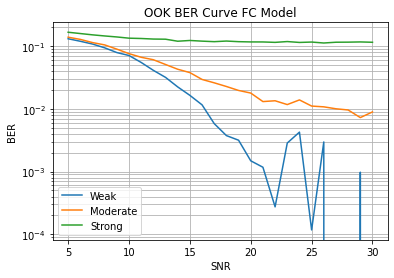

In [ ]:
import matplotlib.pyplot as plot
import numpy as np


plot.grid(True, which="both")
legend = []
for h in y_data.keys():
  plot.semilogy(x_data[:len(y_data[h])],y_data[h])
  legend.append(h)

plot.legend(legend) 
plot.title('OOK BER Curve FC Model')
plot.xlabel('SNR')
plot.ylabel('BER')

plot.show()

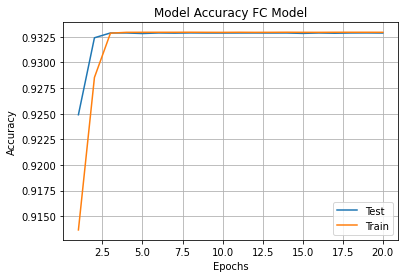

In [ ]:
import matplotlib.pyplot as plot
import numpy as np

eps = 20
plot.grid(True, which="both")
plot.plot(range(1,eps+1),history.history['val_accuracy'])
plot.plot(range(1,eps+1),history.history['accuracy'])
plot.legend(['Test', "Train"])
plot.title('Model Accuracy FC Model')
plot.xlabel('Epochs')
plot.ylabel('Accuracy')

plot.show()

In [ ]:
model.save('model_fc.h5')

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 512, 64)           128       
                                                                 
 batch_normalization_4 (Batc  (None, 512, 64)          256       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 512, 64)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 512, 2)            130       
                                                                 
Total params: 514
Trainable params: 386
Non-trainable params: 128
_________________________________________________________________


In [ ]:
#FLOPs Calculation
def get_flops(model_h5_path):
    session = tf.compat.v1.Session()
    graph = tf.compat.v1.get_default_graph()
        

    with graph.as_default():
        with session.as_default():
            model = tf.keras.models.load_model(model_h5_path)

            run_meta = tf.compat.v1.RunMetadata()
            opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        
            # We use the Keras session graph in the call to the profiler.
            flops = tf.compat.v1.profiler.profile(graph=graph,
                                                  run_meta=run_meta, cmd='op', options=opts)
        
            return flops.total_float_ops

In [ ]:
tf.compat.v1.reset_default_graph()
get_flops('model_fc.h5')

515

In [ ]:
import itertools
import pickle
import torch
import os
import random
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(400)
np.random.seed(400)

#torch.cuda.set_device(1)

class Data(Dataset):
    def __init__(self,x,y):

        self.x=x
        self.y=y
        self.size=len(x)

    @classmethod
    def getReader(cls,type='train'):
      Samp_sel = pd.read_csv('Samp_sel.csv').values
      bit_pattern = pd.read_csv('btp.csv').values
      if(type=="train"):
        Samp_sel = Samp_sel[0:7000,:]
        bit_pattern = bit_pattern[0:7000,:]
      else:
        Samp_sel = Samp_sel[7000:,:]
        bit_pattern = bit_pattern[7000:,:]
      #print(Samp_sel.shape)
      #print(bit_pattern.shape)
      return cls(Samp_sel,bit_pattern)

    def __getitem__(self,idx):
      
      x=self.x[idx]
      y=self.y[idx]
      curr = torch.zeros((y.shape[0],2))
      #print(curr)
      for i,num in enumerate(y):
        num=num.item()
        if num == 0:
            curr[i] = torch.tensor([1,0])
        else:
            curr[i] = torch.tensor([0, 1])
      #print(curr)

      return x,curr

    def __len__(self):
        return self.size


def getLoaders(batch_size=10):
    print('Reading the training Dataset...')
    print()
    train_dataset = Data.getReader(type='train') #19200 #21216
    
    print('Reading the validation Dataset...')
    print()
    valid_dataset = Data.getReader(type='val') #23200 #25216

    
    trainloader = DataLoader(dataset=train_dataset, batch_size = batch_size, num_workers=0,shuffle=True)

    validloader = DataLoader(dataset=valid_dataset, batch_size = batch_size, num_workers=0,shuffle=True)
   
    return trainloader, validloader
train, val = getLoaders()
'''for x,y in train:
  print(x.shape)
  print(y.shape)'''
for x,y in val:
  #print(x.shape)
  print("HI")
  print(y)

In [ ]:
class Model2(nn.Module):
    def __init__(self):
      super(Model2, self).__init__()

      # First fully connected layer
      self.fc1 = nn.Linear(512, 64)

      # Batch normalization 
      self.fc1_bn=nn.BatchNorm1d(64)

      #Relu activation layer
      self.relu = nn.ReLU()

      # First 1D convolutional layer, taking in 1 input channel (image),
      # outputting 32 convolutional features, with a square kernel size of 3
      self.conv1 = nn.Conv1d(64, 2, 1)
    
    def forward(self,input):
      
      #print(input.shape)
      x=self.fc1(input)
      #print(x.shape)
      x=self.fc1_bn(x)
      #print(x.shape)
      x= self.relu(x).unsqueeze(dim=2)
      #print(x.shape)
      x=self.conv1(x)
      #print(x.shape)
      x=F.softmax(x,dim=1)

      return x


my_nn = Model2()

EPOCHS=30
criterion = nn.CrossEntropyLoss()

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in my_nn.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in my_nn.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.01}
]
optimizer = torch.optim.Adam(optimizer_grouped_parameters, lr=0.001) #weight_decay=1e-4)
train_loader,val_loader=getLoaders()
for n in range(EPOCHS):
  my_nn.train()
  final_train_loss=0.0
  final_val_loss=0.0

  for data,y in tqdm(train,desc='TRAINING'):
    y=y.to(torch.long)
    optimizer.zero_grad()
    data=data.type(torch.FloatTensor)
    out=my_nn(data)
    loss =criterion(out, y)
    final_train_loss +=loss.item()
    loss.backward()
    optimizer.step()

  with torch.no_grad():
    for data,y in tqdm(val_loader,desc='VALIDATION'):
      y=y.to(torch.long)
      data=data.to(torch.float64)
      out_val=my_nn(data)
      loss =criterion(out_val, y)
      final_val_loss +=loss.item()

  print("TRAIN_LOSS: {} EVALUATION LOSS {}".format(final_train_loss/len(train_loader),final_val_loss/len(val_loader)))
  print("")